In [1]:
import sys
import os
sys.path.append(os.path.abspath("./MLP"))
sys.path.append(os.path.abspath("./datasets"))
sys.path.append(os.path.abspath("./KAN"))
from MLP import MLP
from MLPWrapper import MLPWrapper
from convert_data_to_input import CreateInput
from KAN import KANWrapper
from KAN_model import KANModel
import torch
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neural_network,pipeline,preprocessing,linear_model
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Prepare data

In [2]:
# get input data
deepmimo = True

function_folder = "seq_sin_pink_-3.32"

data = CreateInput(function_folder, deepmimo)

tensors = data.get_tensors()

           0         1         2         3         4         5         6  \
0  -1.071127 -1.450996 -2.636308 -0.329549  1.806948  1.296416 -0.135281   
1  -0.170276 -0.301575 -0.597102 -1.104663 -1.364563 -0.074106  0.991372   
2   0.572085  0.566875 -1.531421 -1.273426  0.067433 -1.421599  0.149881   
3   0.192757 -1.025377  0.187920 -0.748283 -0.556933  2.589141  1.456760   
4   0.760082  0.611429  0.951301  0.966506 -2.485724 -1.879708 -0.030122   
..       ...       ...       ...       ...       ...       ...       ...   
65 -0.564578  0.900035  2.013946 -1.208904  0.709127 -0.188264  0.551594   
66 -0.116741 -0.586607 -1.699672 -1.413316 -0.153026 -0.177135  0.802231   
67  0.873958 -0.945411 -1.499962 -1.318186 -0.230880  1.294361 -0.392952   
68  1.294384  0.157060 -0.481691 -1.494932 -0.351063  0.130868  0.154464   
69 -1.020470 -0.851054 -1.218941 -1.762148 -1.213100 -0.331554  1.601328   

           7         8         9  ...        20        21        22        23  \
0   2.

In [3]:
print(type(data))

<class 'convert_data_to_input.CreateInput'>


In [4]:
tensors['test'][1].shape

torch.Size([20, 30])

# Evaluate KAN

In [5]:
# find optimal params for KAN

kan_wrapper = KANWrapper(data=tensors,deepmimo=deepmimo)
input_size = tensors['test'][1].shape[1]

if deepmimo:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[input_size, 10, input_size], [input_size, 5, input_size], [input_size, 4, input_size], [input_size, 3, input_size], [input_size, 2, input_size]],
        'kan__grid': [3],
        'kan__k': [5],
        'kan__seed': [42],
        'kan__lr': [0.001],
        'kan__lamb': [0],
        'kan__deepmimo': [True],
        'kan__epochs': [1]
    }

else:
    param_grid = {
        'kan__data': [tensors],
        'kan__width': [[1, 3, 1], [1, 3, 3, 1], [1, 3, 3, 3, 1], [1, 3, 1], [1, 5, 5, 1], [1, 5, 5, 5, 1], [1, 7, 1], [1, 7, 7, 1], [1, 7, 7, 7, 1]],
        'kan__grid': [3],
        'kan__k': [5],
        'kan__seed': [42],
        'kan__lr': [0.001, 0.0001],
        'kan__lamb': [0],
        'kan__deepmimo': [False],
        'kan__epochs': [20]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kan', kan_wrapper)
])

# Initialize RandomizedSearchCV
"""grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,                           # Number of parameter settings sampled
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=2
)"""
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,                                  # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=2
)
# Fit RandomizedSearchCV
grid_search.fit(kan_wrapper.X_train, kan_wrapper.y_train)

# Retrieve the best parameters and best score
grid_search.best_params_['kan__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_KAN = grid_search.best_params_


Fitting 5 folds for each of 5 candidates, totalling 25 fits


| train_loss: 1.28e-01 | test_loss: 1.21e+00 | reg: 6.43e+01 | : 100%|█| 1/1 [00:01<00:00,  1.12s/it
| train_loss: 2.06e-01 | test_loss: 1.88e+00 | reg: 6.81e+01 | : 100%|█| 1/1 [00:01<00:00,  1.10s/it


[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 8.57e-02 | test_loss: 1.32e+00 | reg: 3.64e+01 | : 100%|█| 1/1 [00:01<00:00,  1.14s/it
| train_loss: 1.21e-01 | test_loss: 2.10e+00 | reg: 6.23e+01 | : 100%|█| 1/1 [00:01<00:00,  1.20s/it
| train_loss: 9.69e-02 | test_loss: 1.86e+00 | reg: 3.77e+01 | : 100%|█| 1/1 [00:01<00:00,  1.16s/it
| train_loss: 1.11e-01 | test_loss: 1.88e+00 | reg: 6.27e+01 | : 100%|█| 1/1 [00:01<00:00,  1.32s/it
| train_loss: 1.20e-01 | test_loss: 1.71e+00 | reg: 6.46e+01 | : 100%|█| 1/1 [00:01<00:00,  1.17s/it


[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 9.20e-02 | test_loss: 1.86e+00 | reg: 3.77e+01 | : 100%|█| 1/1 [00:01<00:00,  1.29s/it
| train_loss: 8.26e-02 | test_loss: 2.34e+00 | reg: 3.74e+01 | : 100%|█| 1/1 [00:00<00:00,  2.09it/s


[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 7.73e-02 | test_loss: 3.63e+00 | reg: 3.68e+01 | : 100%|█| 1/1 [00:00<00:00,  1.44it/s
| train_loss: 3.55e-01 | test_loss: 1.72e+00 | reg: 3.78e+01 | : 100%|█| 1/1 [00:00<00:00,  1.85it/s
| train_loss: 1.45e-01 | test_loss: 1.19e+00 | reg: 4.14e+01 | : 100%|█| 1/1 [00:00<00:00,  1.71it/s


[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 2.68e-01 | test_loss: 1.36e+00 | reg: 3.88e+01 | : 100%|█| 1/1 [00:00<00:00,  1.64it/s
| train_loss: 2.10e-01 | test_loss: 1.06e+00 | reg: 3.67e+01 | : 100%|█| 1/1 [00:00<00:00,  2.30it/s



[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.135

| train_loss: 2.27e-01 | test_loss: 1.39e+00 | reg: 3.88e+01 | : 100%|█| 1/1 [00:00<00:00,  1.70it/s


[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 2.83e-01 | test_loss: 1.14e+00 | reg: 3.85e+01 | : 100%|█| 1/1 [00:00<00:00,  2.11it/s
| train_loss: 3.25e-01 | test_loss: 1.33e+00 | reg: 3.78e+01 | : 100%|█| 1/1 [00:00<00:00,  1.34it/s
| train_loss: 1.89e-01 | test_loss: 2.16e+00 | reg: 3.93e+01 | : 100%|█| 1/1 [00:00<00:00,  1.11it/s
| train_loss: 2.82e-01 | test_loss: 2.59e+00 | reg: 3.84e+01 | : 100%|█| 1/1 [00:00<00:00,  1.65it/s
| train_loss: 4.11e-01 | test_loss: 2.24e+00 | reg: 2.98e+01 | : 100%|█| 1/1 [00:00<00:00,  2.04it/s
| train_loss: 3.13e-01 | test_loss: 1.02e+00 | reg: 3.82e+01 | : 100%|█| 1/1 [00:00<00:00,  1.51it/s
| train_loss: 3.84e-01 | test_loss: 4.04e+00 | reg: 3.36e+01 | : 100%|█| 1/1 [00:00<00:00,  1.98it/s


[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 3.63e-01 | test_loss: 5.25e+00 | reg: 2.55e+01 | : 100%|█| 1/1 [00:00<00:00,  2.51it/s
| train_loss: 4.80e-01 | test_loss: 2.83e+00 | reg: 3.92e+01 | : 100%|█| 1/1 [00:00<00:00,  2.25it/s
| train_loss: 4.34e-01 | test_loss: 3.35e+00 | reg: 2.91e+01 | : 100%|█| 1/1 [00:00<00:00,  2.45it/s


[CV] END kan__data={'train': (tensor([[-1.0711, -1.4510, -2.6363,  ...,  0.4259, -0.9136, -1.7717],
        [-0.1703, -0.3016, -0.5971,  ...,  0.9312,  0.7050, -0.6900],
        [ 0.5721,  0.5669, -1.5314,  ...,  2.5869,  0.3795, -1.8531],
        ...,
        [ 0.8740, -0.9454, -1.5000,  ...,  1.0592, -1.5760, -1.2559],
        [ 1.2944,  0.1571, -0.4817,  ...,  1.5823,  0.6209,  1.0818],
        [-1.0205, -0.8511, -1.2189,  ...,  1.5855,  2.6655, -0.1116]]), tensor([[ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        ...,
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440],
        [ 0.5440, -0.1142, -0.7202,  ...,  0.7202,  0.1142, -0.5440]])), 'test': (tensor([[ 1.4875e+00,  4.4163e-01, -2.3036e+00, -3.1205e-01, -6.4209e-02,
         -9.1356

| train_loss: 1.52e-01 | test_loss: 1.04e+00 | reg: 3.50e+01 | : 100%|█| 1/1 [00:00<00:00,  1.55it/s

Best Parameters: {'kan__data': [], 'kan__deepmimo': True, 'kan__epochs': 1, 'kan__grid': 3, 'kan__k': 5, 'kan__lamb': 0, 'kan__lr': 0.001, 'kan__seed': 42, 'kan__width': [[30, 0], [3, 0], [30, 0]]}
Best Cross-Validation Score: -0.5966686427593231


In [ ]:
# evaluate KAN with optimal params
kan_model = KANModel(width=opt_params_KAN['kan__width'], grid=opt_params_KAN['kan__grid'], k=opt_params_KAN['kan__k'], seed=opt_params_KAN['kan__seed'], lr=opt_params_KAN['kan__lr'], lamb=opt_params_KAN['kan__lamb'], deepmimo=deepmimo, epochs=10)

kan_model.load_data(tensors)
loss_data, time_elapsed = kan_model.fit()
y_preds = kan_model.predict()


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.31e-04 | test_loss: 2.13e-01 | reg: 1.28e+01 | : 100%|█| 100/100 [00:09<00:00, 10.68


saving model version 0.1


In [7]:
"""print(y_preds['preds'][0].shape)
x=np.linspace(-10, 10, 20)
many_x = np.linspace(-10, 10, 200)
plt.plot(x, y_preds['preds'][0], "o")
plt.plot(many_x, np.sin(many_x))
plt.plot(x, tensors['train'][0][0], ".")
plt.show()"""

'print(y_preds[\'preds\'][0].shape)\nx=np.linspace(-10, 10, 20)\nmany_x = np.linspace(-10, 10, 200)\nplt.plot(x, y_preds[\'preds\'][0], "o")\nplt.plot(many_x, np.sin(many_x))\nplt.plot(x, tensors[\'train\'][0][0], ".")\nplt.show()'

In [8]:
"""if deepmimo:
    kan_model = KANModel(width=[20, 10,10, 20], grid=20, k=3, seed=42, lr=0.1, lamb=0,deepmimo=deepmimo,steps=10)
    kan_model.load_data(tensors)
    loss_data, time_elapsed = kan_model.fit()
    y_preds = kan_model.predict()"""

'if deepmimo:\n    kan_model = KANModel(width=[20, 10,10, 20], grid=20, k=3, seed=42, lr=0.1, lamb=0,deepmimo=deepmimo,steps=10)\n    kan_model.load_data(tensors)\n    loss_data, time_elapsed = kan_model.fit()\n    y_preds = kan_model.predict()'

torch.Size([30])
30


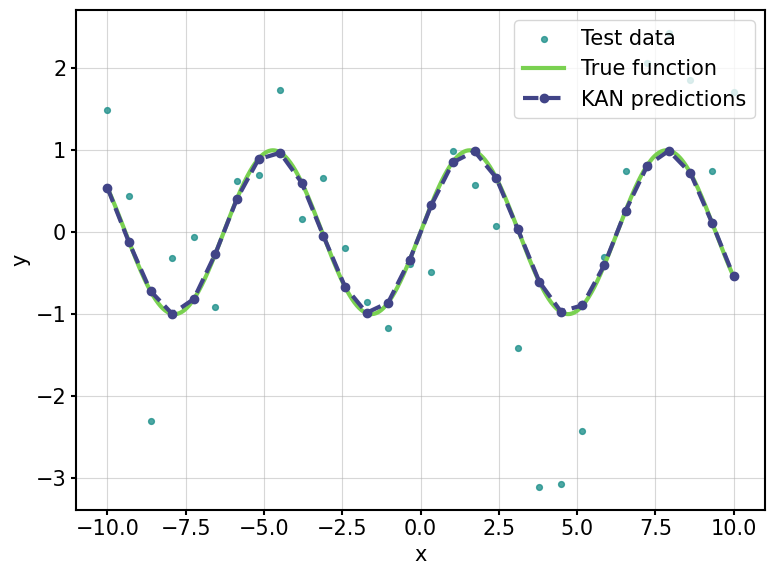

In [15]:
# plot pred and true
if deepmimo:
    #kan_model.plot_deepmimo(data=tensors, y_preds=y_preds['preds'], type_='test', save=False)
    kan_model.plot_sequence(data=tensors, y_preds=y_preds['preds'], type_='test', save=False)
else:
    kan_model.plot_prediction(data=tensors, y_preds=y_preds['preds'], type_='test', save=False)

In [16]:
# plot noise and true
# if deepmimo:
#     kan_model.plot_deepmimo(data=tensors, y_preds=tensors['test'][0][:2,:], type_='test', save=False)

In [17]:
# diffrence in noise and true
#torch.sum(np.abs(tensors['test'][0][:1,:] - tensors['test'][1][:1,:]))

In [18]:
# diffrence pred and true
#torch.sum(np.abs(y_preds['preds'][0] - tensors['test'][1][:1,:]))

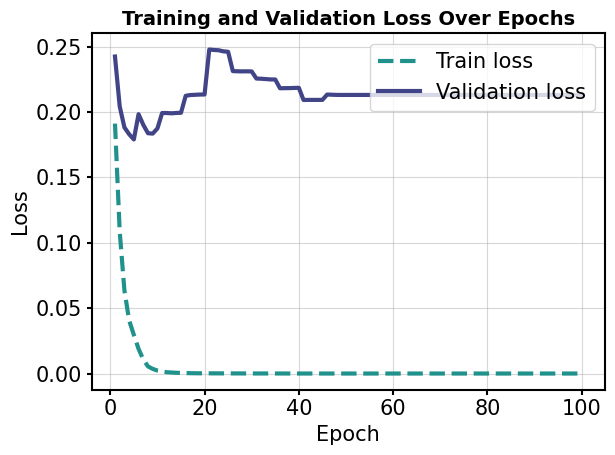

In [19]:
# plot loss
kan_model.plot_loss(loss_data=loss_data, save=False)

# Evaluate MLP

In [20]:
# find optimal params for mlp
mlp_wrapper = MLPWrapper(data=tensors,deepmimo=deepmimo)

if deepmimo:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [1024],
        'mlp__hidden_size': [[64,64],[500,500],[2000],[1000,1000],[300,300,300],[5000],[3000,3000],[32,32],[128,128],[256,64]],
        'mlp__output_size': [1024],
        'mlp__epochs': [100],
        'mlp__deepmimo': [True]
    }

else:
    param_grid = {
        'mlp__data': [tensors],
        'mlp__input_size': [1],
        'mlp__hidden_size': [[3], [3, 3], [3, 3, 3], [5], [5, 5], [5, 5, 5], [7], [7, 7], [7, 7, 7]],
        'mlp__output_size': [1],
        'mlp__epochs': [20, 21],
        'mlp__deepmimo': [False],
        'mlp__lr': [0.001]
    }


# (Optional) Create a pipeline if preprocessing is needed
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Example preprocessor
    ('mlp', mlp_wrapper)
])

# Initialize RandomizedSearchCV
grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,  # Number of parameter settings sampled
    cv=5,        # 5-Fold Cross-Validation
    scoring='neg_mean_squared_error',  # Appropriate for regression
    random_state=42,                    # For reproducibility
    n_jobs=-1,                          # Utilize all CPU cores
    verbose=0
)

# Fit RandomizedSearchCV
grid_search.fit(mlp_wrapper.X_train, mlp_wrapper.y_train)

# Retrieve the best parameters and best score
grid_search.best_params_['mlp__data'] = []          # remove annoying print
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

opt_params_MLP = grid_search.best_params_

/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/100 [00:00<?, ?it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%|          | 0/100 [00:00<?, ?it/s]/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y).float()
  0%

ValueError: 
All the 25 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/home/anton/miniconda3/envs/pykan-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/anton/miniconda3/envs/pykan-env/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLPWrapper.py", line 67, in fit
    self.model.fit(X_, y_, n_epochs=self.epochs, cross_validation=True, deepmimo=self.deepmimo)
  File "/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLP.py", line 109, in fit
    loss = self.optimizer.step(closure)
  File "/home/anton/miniconda3/envs/pykan-env/lib/python3.9/site-packages/torch/optim/optimizer.py", line 385, in wrapper
    out = func(*args, **kwargs)
  File "/home/anton/miniconda3/envs/pykan-env/lib/python3.9/site-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "/home/anton/miniconda3/envs/pykan-env/lib/python3.9/site-packages/torch/optim/lbfgs.py", line 314, in step
    orig_loss = closure()
  File "/home/anton/miniconda3/envs/pykan-env/lib/python3.9/site-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLP.py", line 98, in closure
    output = self.forward(X)
  File "/home/anton/Documents/kth/KAN-Kolmogorov-Arnold-Networks/MLP/MLP.py", line 64, in forward
    return self.layers(x)
  File "/home/anton/miniconda3/envs/pykan-env/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/anton/miniconda3/envs/pykan-env/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/anton/miniconda3/envs/pykan-env/lib/python3.9/site-packages/torch/nn/modules/container.py", line 217, in forward
    input = module(input)
  File "/home/anton/miniconda3/envs/pykan-env/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/anton/miniconda3/envs/pykan-env/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/anton/miniconda3/envs/pykan-env/lib/python3.9/site-packages/torch/nn/modules/linear.py", line 116, in forward
    return F.linear(input, self.weight, self.bias)
RuntimeError: mat1 and mat2 shapes cannot be multiplied (56x30 and 1024x1)


In [ ]:
# evaluate KAN with optimal params
mlp_model = MLP(input_size=opt_params_MLP['mlp__input_size'], hidden_sizes=opt_params_MLP['mlp__hidden_size'], output_size=opt_params_MLP['mlp__output_size'])
mlp_model.load_data(tensors, deepmimo=deepmimo)
loss_data_MLP, time_elapsed_MLP = mlp_model.fit(mlp_model.X_train, mlp_model.y_train, n_epochs=100, cross_validation=False, deepmimo=deepmimo)
y_preds_MLP = mlp_model.predict(mlp_model.X_test,eval=True)

In [ ]:
# plot predictions
if deepmimo:
    mlp_model.plot_deepmimo(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=False)
else:
    mlp_model.plot_prediction(data=tensors, y_preds=y_preds_MLP['preds'], type_='test', save=False)

In [ ]:
# plot loss

mlp_model.plot_loss(loss_data=loss_data_MLP, save=False, deepmimo=deepmimo)